- Getting USGS **Earthquake Data** via Catalog API

In [2]:
import subprocess

url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
output_file = "earthquake_data.csv"

subprocess.run(["curl", "-o", output_file, url], check=True)

CompletedProcess(args=['curl', '-o', 'earthquake_data.csv', 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv'], returncode=0)

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, avg

spark = SparkSession.builder \
    .appName("Earthquake Data Transformation") \
    .getOrCreate()

df = spark.read.option("header", True).option(
    "inferSchema", True).csv("earthquake_data.csv")

In [6]:
df_filtered = df.filter((col("mag").isNotNull()) & (col("mag") > 0))

In [9]:
df_filtered.show()

+--------------------+---------------+----------------+---------------+----+-------+----+-----------+-------------+------------+---+------------+--------------------+--------------------+------------+---------------+-----------+----------------+------+---------+--------------+---------+
|                time|       latitude|       longitude|          depth| mag|magType| nst|        gap|         dmin|         rms|net|          id|             updated|               place|        type|horizontalError| depthError|        magError|magNst|   status|locationSource|magSource|
+--------------------+---------------+----------------+---------------+----+-------+----+-----------+-------------+------------+---+------------+--------------------+--------------------+------------+---------------+-----------+----------------+------+---------+--------------+---------+
|2025-05-14 01:28:...|      33.604332|    -116.7454987|          10.56|1.54|     ml|  30|       47.0|      0.03943|        0.29| ci|  ci

In [10]:
df_with_time = df_filtered.withColumn("year", year(col("time"))) \
                          .withColumn("month", month(col("time")))

In [11]:
df_with_time.show()

+--------------------+---------------+----------------+---------------+----+-------+----+-----------+-------------+------------+---+------------+--------------------+--------------------+------------+---------------+-----------+----------------+------+---------+--------------+---------+----+-----+
|                time|       latitude|       longitude|          depth| mag|magType| nst|        gap|         dmin|         rms|net|          id|             updated|               place|        type|horizontalError| depthError|        magError|magNst|   status|locationSource|magSource|year|month|
+--------------------+---------------+----------------+---------------+----+-------+----+-----------+-------------+------------+---+------------+--------------------+--------------------+------------+---------------+-----------+----------------+------+---------+--------------+---------+----+-----+
|2025-05-14 01:28:...|      33.604332|    -116.7454987|          10.56|1.54|     ml|  30|       47.0|  

In [12]:
df_agg = df_with_time.groupBy("year", "month").agg(
    avg("mag").alias("average_magnitude")
)

df_agg.show()

+----+-----+------------------+
|year|month| average_magnitude|
+----+-----+------------------+
|2025|    5| 1.703128015904062|
|2025|    4|1.6411137440904107|
+----+-----+------------------+



Following this, I created a script that creates a parquet file for this data.

Then, the following steps followed:
- organizing the 3 scripts into a 'scripts' folder
- creating an empty 'data' folder for the csvs and parquet storage
- creating a .env file, where I set 'AIRFLOW_UID=50000' to avoid permission issues between Docker and Windows
- created a dag file in new folder 'dags' named: etl_pipeline.py to use on airflow later
- created yaml by executing: 'Invoke-WebRequest -Uri "https://airflow.apache.org/docs/apache-airflow/2.8.1/docker-compose.yaml" -OutFile "docker-compose.yaml"' in powershell
- started up docker desktop and ran 'docker-compose up airflow-init' in powershell
- finally, executed 'docker-compose up -d' to start up airflow UI

This opens Airflow UI on localhost. From here:
- I selected the dag file (earthquake_etl_pipeline)
- Toggled Unpause for the dag on left-hand side
- Select Trigger DAG via the blue play button on right-hand side
- Waited for all tasks to pass through the states until all 3 turned green (success)

**Final States after running on Airflow:**

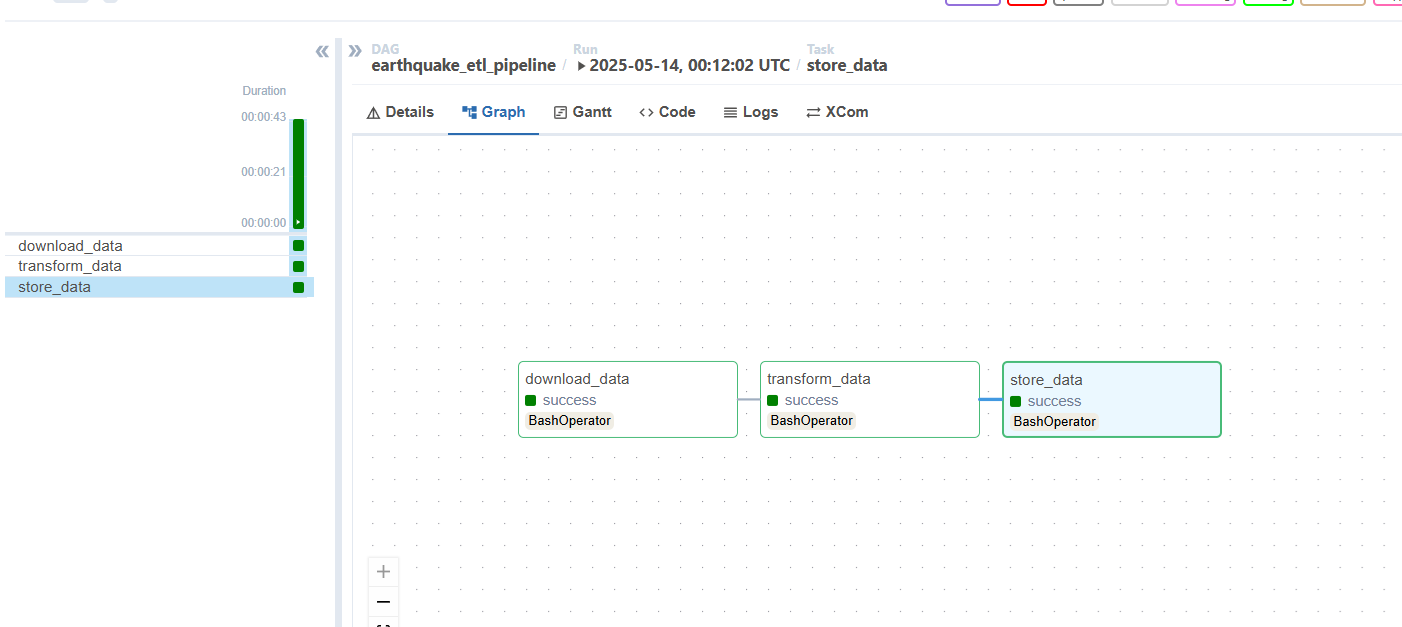

---